[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/CurseOfDimensionality.ipynb)


# Curse of Dimensionality

Some learning algorithms use a distance function to measure the similarity or dissimilarity of instances. Having many features corresponds to the instance "living" in a high-dimensional space. High dimensional data introduce difficulties, so called curse of dimensionality. However, by making some strong assumption about the data machine learning methods overcome these difficulties. First lets see the problems associated with high-dimensional data:

1. To "fill" a high dimensional space we need exponentially more samples.
- in one dimension, it is enough to have 9 labeled examples in the range (0,10), to make sure any new observation will be at a distance of `1` to our training data.
- in two dimensions, we need more than $9 \times 9$ labeled examples to satisfy the same condition.
- the number of required samples is $\mathcal{O}(9^D)$, where $D$ is the dimension.

2. In high dimension, it becomes harder to identify close neighbours. Let us demonstrate this with an example. We will generate random instances in various dimensions and measure the pairwise distance between these examples. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

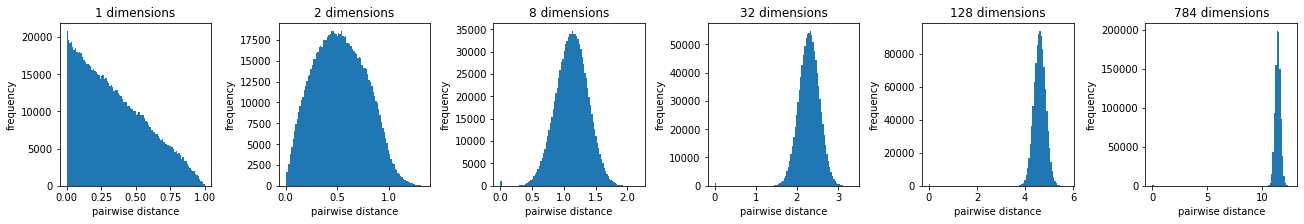

In [2]:
N = 1000                                #number of randomly generated points
Ds = [1, 2, 8, 32, 128, 784]            #array for different dimensions we'll consider
fig, axes = plt.subplots(ncols=len(Ds), nrows=1, constrained_layout=True, figsize=(len(Ds)*3, 3))
for i, D in enumerate(Ds):
    #generate random samples in a D dimensional space
    x = np.random.rand(N,D)
    #next compute the pairwise euclidean distance between the generated points (remember broadcasting?)
    dist = np.sqrt(np.sum((x[None,:,:] - x[:,None,:])**2, -1))
    axes[i].hist(dist.ravel(), bins=100)              #to plot a histogram
    axes[i].set_xlabel("pairwise distance")
    axes[i].set_ylabel("frequency")
    axes[i].set_title(f'{D} dimensions')
plt.show()


It is evident from this plot that, very unintuitively, in high dimensions, most points in the space have similar distances with each other!
If our datasets had a similar behaviour this could undermine learning in high-dimensions:
if all instances are more or less similar to each other on what basis can we label them differently?
Let's create similar plots for the `MNIST` dataset. For each dimension `D` we randomly select subset of dimensions from the `28 x 28 = 784` dimensions, and use them to measure the pairwise distance between examples.

In [3]:
#load the MNIST dataset
from sklearn.datasets import fetch_openml
x_org, y = fetch_openml('mnist_784', version=1, return_X_y=True)

Lets see what the data looks like

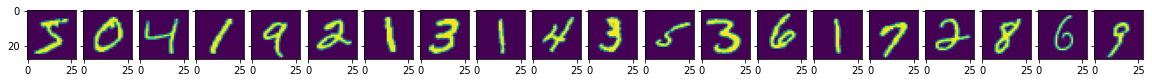

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_digits(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)  #makes a grid of images
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((28,28)))
    plt.show()
plot_digits(x_org[:20])

Now let's do the same measurement of pairwise distance, this time between instances in our dataset

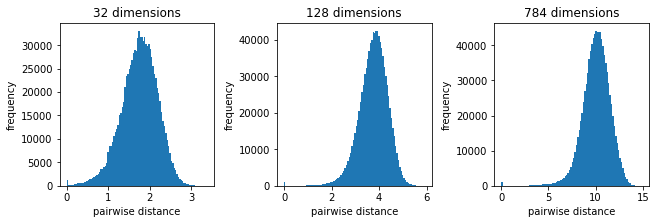

In [6]:
N = 1000 # number of examples to use (for faster computation)
x = np.reshape(x_org[:N], (N, -1))              #this flattens the images
x = x / np.max(x)                               #normalize
Ds = [32, 128, 784]
fig, axes = plt.subplots(ncols=len(Ds), nrows=1, constrained_layout=True, figsize=(len(Ds)*3, 3))
dim_inds = np.random.permutation(x.shape[1])
for i, D in enumerate(Ds):
    #randomly slice D dimensions from the data 
    x_D = x[:,dim_inds[:D]]
    #compute the pairwise euclidean distance between the N data samples
    dist = np.sqrt(np.sum((x_D[None,:,:] - x_D[:,None,:])**2, -1))
    axes[i].hist(dist.ravel(), bins=100)
    axes[i].set_xlabel("pairwise distance")
    axes[i].set_ylabel("frequency")
    axes[i].set_title(f'{D} dimensions')
plt.show()

This difference between real-world data and random data is explained by the **manifold hypothesis**. This hypothesis postulates that real-world data often reside close to high-dimensional *manifold*. Dimensionality reduction methods (aka manifold learning) try to estimate these low-dimensional encoding of the data. However, the point we wanted to show here is that because of this special behaviour, methods such as KNN continue to work with high-dimensional data.

## Another demonstration
We put one hypercube inside another with unit length, such that they have one common corner. We then place a large number of points regularly inside the larger hypercube.
Here again we change the dimension of the hypercubes and plot the portion of the points in the large hypercube that are also in the small hypercube (think of this as the portion of their volume) as we change the length of the side of the smaller hypercube.

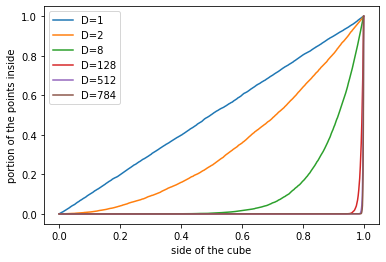

In [7]:
Ds = [1, 2,  8, 128, 512, 784]
N = 10000
grid_size = 1000
#generate grid points
grid_points = np.linspace(0,1,grid_size, endpoint=True)
result = np.zeros((len(Ds), grid_size))
for j, D in enumerate(Ds):
    x = np.random.rand(N, D)
    for i, g in enumerate(grid_points):
        result[j,i] = np.sum(np.all(x < g, axis=1)) / N        #all the samples that fall in the cube of size g/grid_size
    plt.plot(grid_points, result[j,:], label=f'D={D}')
    plt.xlabel('side of the cube')
    plt.ylabel('portion of the points inside')
plt.legend()
plt.show()

that is to get 1% of the points to be inside the inner cube we need to have a side of length .993! This is another expression of the idea that in high dimensions, *the mass is mostly at the corners!*

to get 1% of points inside the inner cube for D=784 we need the side of the cube to be of length 0.993


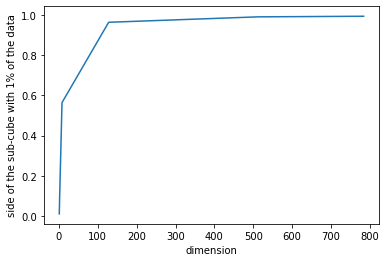

In [8]:
#get the length of the sides
side_length = np.argmin(np.abs(result - .01), axis=1)/grid_size
plt.plot(Ds, side_length)
plt.xlabel('dimension')
plt.ylabel('side of the sub-cube with 1% of the data')
print(f'to get 1% of points inside the inner cube for D=784 we need the side of the cube to be of length {side_length[-1]}')